# Análise e Implementação do Dataset de Tradução Inglês-Francês com TensorFlow
Este notebook tem como objetivo realizar o processamento, tokenização e análise de um dataset de tradução Inglês-Francês utilizando a biblioteca `d2l` e o framework TensorFlow. Abaixo, explicamos cada etapa do código fornecido.

Fontes:
- https://pt.d2l.ai/chapter_recurrent-modern/machine-translation-and-dataset.html#
- https://d2l.ai/chapter_recurrent-modern/seq2seq.html
- [Sub-Character Tokenization for Chinese Pretrained Models](https://direct.mit.edu/tacl/article/doi/10.1162/tacl_a_00560/116047/Sub-Character-Tokenization-for-Chinese-Pretrained)  
- [Japanese Tokenization Methods](https://jamessullivan.github.io/blog/programming/japanese-tokenization/)


## Importação das Bibliotecas Necessárias

A primeira etapa envolve a importação das bibliotecas utilizadas no processo. A biblioteca `os` é usada para operações de sistema, enquanto `torch` e `d2l` são utilizados para modelagem de aprendizado de máquina e implementação de modelos.

Como d2l não faz parte da lista de pacotes previamente instalados no ambiente do colab, precisamos fazer a instalação de forma manual.

In [85]:
!pip install d2l
!pip install mxnet

In [86]:
import os
import tensorflow as tf
from d2l import tensorflow as d2l
import math
import collections

## Download do Dataset
Utilizando o `d2l`, baixamos o dataset de tradução Inglês-Francês.
A função `read_data_nmt()` faz o download e a extração dos dados, retornando o conteúdo do arquivo como uma string de texto.

In [87]:
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

def read_data_nmt():
    """Load the English-French dataset."""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



## Processamento de Texto
Na sequência, o texto é pré-processado,onde caracteres especiais de quebra de linha são substituídos por espaços comuns, e letras maiúsculas são convertidas para minúsculas.

Esta função [preprocess_nmt] também adiciona espaços entre palavras e sinais de pontuação, preparando o texto para tokenização.

In [88]:
def preprocess_nmt(text):
    """Preprocess the English-French dataset."""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


## Tokenização
A função `tokenize_nmt` divide as sentenças de origem e destino em listas de tokens (palavras).

Aqui, as sentenças são separadas em listas de palavras para posterior processamento.

In [89]:
def tokenize_nmt(text, num_examples=None):
    """Tokenize the English-French dataset."""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

## Análise do Comprimento das Sentenças
Gera-se um histograma para visualizar os comprimentos das sentenças no idioma de origem e no de destino.


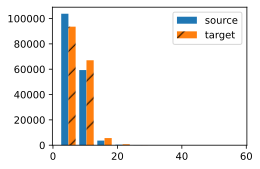

In [90]:
d2l.set_figsize()
_, _, patches = d2l.plt.hist(
    [[len(l) for l in source], [len(l) for l in target]],
    label=['source', 'target'])
for patch in patches[1].patches:
    patch.set_hatch('/')
d2l.plt.legend(loc='upper right')

## Criação do Vocabulário
Um vocabulário é construído para ambos os idiomas, utilizando apenas palavras com frequência mínima de 2.

In [91]:
src_vocab = d2l.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

## Truncamento e Padding
Para que as sequências tenham um comprimento fixo, as sequências são preenchidas com tokens especiais.  (`<pad>`).


In [92]:
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[3919, 80, 208, 208, 208, 208, 208, 208, 208, 208]

## Preparação dos Dados para o Treinamento
Agora, as sentenças são transformadas em arrays de tensores, e um iterador de dados é criado para alimentar o modelo de tradução.

In [93]:
def build_array_nmt(lines, vocab, num_steps):
    """Transform text sequences of machine translation into minibatches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = tf.constant([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = tf.reduce_sum(
        tf.cast(array != vocab['<pad>'], tf.int32), 1)
    return array, valid_len

## Carregamento dos Dados e Execução
A função `load_data_nmt` retorna os iteradores de dados e os vocabulários gerados. Após isso, os dados são carregados e o modelo de tradução está pronto para ser treinado.


In [94]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Return the iterator and the vocabularies of the translation dataset."""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

## Visualização do Crescimento do Vocabulário
Finalmente, é feito um experimento para visualizar como o tamanho do vocabulário cresce à medida que o número de exemplos aumenta.


In [95]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', tf.cast(X, tf.int32))
    print('valid lengths for X:', X_valid_len)
    print('Y:', tf.cast(Y, tf.int32))
    print('valid lengths for Y:', Y_valid_len)
    break

X: tf.Tensor(
[[173 101   2   4   5   5   5   5]
 [ 81  39   2   4   5   5   5   5]], shape=(2, 8), dtype=int32)
valid lengths for X: tf.Tensor([4 4], shape=(2,), dtype=int32)
Y: tf.Tensor(
[[124   6   2   4   5   5   5   5]
 [100 117 171   6   2   4   5   5]], shape=(2, 8), dtype=int32)
valid lengths for Y: tf.Tensor([4 6], shape=(2,), dtype=int32)


### Plotando o crescimento dos vocabulários
Esse gráfico nos permite analisar como o vocabulário de origem e de destino evolui conforme aumentamos o número de exemplos no dataset.

É possível observar como o aumento no número de exemplos afeta diretamente os tamanhos dos vocabulários dos idiomas de origem e de destino. À medida que mais exemplos são utilizados no treinamento, o tamanho do vocabulário aumenta de forma proporcional. Esse crescimento ocorre de maneira linear tanto para o idioma de origem quanto para o de destino. No entanto, o vocabulário do idioma de destino cresce mais rapidamente.

Number of examples: 50
Source vocabulary size: 26
Target vocabulary size: 22

Number of examples: 100
Source vocabulary size: 40
Target vocabulary size: 40

Number of examples: 200
Source vocabulary size: 69
Target vocabulary size: 67

Number of examples: 500
Source vocabulary size: 159
Target vocabulary size: 163

Number of examples: 1000
Source vocabulary size: 266
Target vocabulary size: 321

Number of examples: 2000
Source vocabulary size: 454
Target vocabulary size: 585

Number of examples: 5000
Source vocabulary size: 875
Target vocabulary size: 1231



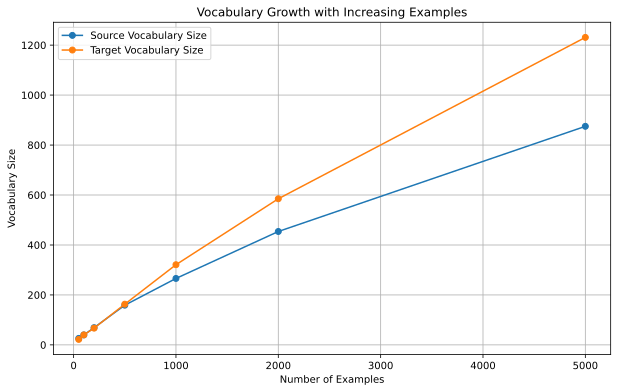

In [96]:
import matplotlib.pyplot as plt

num_examples_values = [50, 100, 200, 500, 1000, 2000, 5000]

source_vocab_sizes = []
target_vocab_sizes = []

for num_examples in num_examples_values:
    train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8, num_examples=num_examples)
    source_vocab_sizes.append(len(src_vocab))
    target_vocab_sizes.append(len(tgt_vocab))
    print(f"Number of examples: {num_examples}")
    print(f"Source vocabulary size: {len(src_vocab)}")
    print(f"Target vocabulary size: {len(tgt_vocab)}\n")
plt.figure(figsize=(10, 6))
plt.plot(num_examples_values, source_vocab_sizes, label="Source Vocabulary Size", marker='o')
plt.plot(num_examples_values, target_vocab_sizes, label="Target Vocabulary Size", marker='o')
plt.xlabel("Number of Examples")
plt.ylabel("Vocabulary Size")
plt.title("Vocabulary Growth with Increasing Examples")
plt.legend()
plt.grid(True)
plt.show()


### Definição do **Seq2SeqEncoder** (Codificador)
O **Seq2SeqEncoder** é um codificador baseado em RNNs, responsável por receber a sequência de entrada (frases em um idioma) e produzir um vetor de contexto. Ele usa embeddings e camadas GRU para processar a entrada. As seções de código abaixo foram extraidas do tutorial.

In [97]:
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn, rnn
from d2l import mxnet as d2l
npx.set_np()


class Seq2SeqEncoder(d2l.Encoder):
    """The RNN encoder for sequence-to-sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(num_hiddens, num_layers, dropout)
        self.initialize(init.Xavier())

    def forward(self, X, *args):
        embs = self.embedding(d2l.transpose(X))
        outputs, state = self.rnn(embs)
        return outputs, state

### Definição do **Seq2SeqDecoder** (Decodificador)
O decodificador recebe o vetor de contexto gerado pelo codificador e aprende a traduzir essa representação em uma sequência no idioma alvo. O decodificador também usa GRU e embeddings.

In [98]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = np.zeros((batch_size, num_steps))
enc_outputs, enc_state = encoder(X)
d2l.check_shape(enc_outputs, (num_steps, batch_size, num_hiddens))

### Instanciação e Teste do Decodificador
Instanciamos e testamos o decodificador para garantir que ele processe corretamente o vetor de contexto.


In [99]:
d2l.check_shape(enc_state, (num_layers, batch_size, num_hiddens))

In [100]:
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(num_hiddens, num_layers, dropout)
        self.dense = nn.Dense(vocab_size, flatten=False)
        self.initialize(init.Xavier())

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def forward(self, X, state):
        embs = self.embedding(d2l.transpose(X))
        enc_output, hidden_state = state
        context = enc_output[-1]
        context = np.tile(context, (embs.shape[0], 1, 1))
        embs_and_context = np.concatenate((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        return outputs, [enc_output, hidden_state]

In [101]:
decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
state = decoder.init_state(encoder(X))
dec_outputs, state = decoder(X, state)
d2l.check_shape(dec_outputs, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[1], (num_layers, batch_size, num_hiddens))

### Definição da Classe **Seq2Seq**
Essa classe conecta o codificador e o decodificador, formando o modelo completo Seq2Seq.

In [102]:
class Seq2Seq(d2l.EncoderDecoder):
    """The RNN encoder--decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        return gluon.Trainer(self.parameters(), 'adam',
                             {'learning_rate': self.lr})

In [103]:
@d2l.add_to_class(Seq2Seq)
def loss(self, Y_hat, Y):
    l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
    mask = (Y.reshape(-1) != self.tgt_pad).astype(np.float32)
    return (l * mask).sum() / mask.sum()

### 16. Treinamento do Modelo
Aqui, configuramos o modelo com o otimizador Adam e usamos a função de perda customizada com masking para ignorar os tokens de padding.

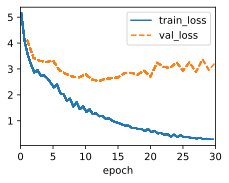

In [104]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

### 17. Predição e Cálculo do BLEU
O método de predição usa o modelo treinado para prever traduções, e o método `bleu` calcula a qualidade da tradução comparando a sequência prevista com a verdadeira.

In [105]:
@d2l.add_to_class(d2l.EncoderDecoder)
def predict_step(self, batch, device, num_steps,
                 save_attention_weights=False):
    batch = [a.as_in_context(device) for a in batch]
    src, tgt, src_valid_len, _ = batch
    enc_all_outputs = self.encoder(src, src_valid_len)
    dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
    outputs, attention_weights = [np.expand_dims(tgt[:, 0], 1), ], []
    for _ in range(num_steps):
        Y, dec_state = self.decoder(outputs[-1], dec_state)
        outputs.append(Y.argmax(2))
        if save_attention_weights:
            attention_weights.append(self.decoder.attention_weights)
    return np.concatenate(outputs[1:], 1), attention_weights

In [106]:
def bleu(pred_seq, label_seq, k):
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [107]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['je', 'suis', '<unk>', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000
